# Calculate power output

Using generation capacities of each facility, multiplied by the capacity factor time series for each nearest grid box.

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [27]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "02:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [28]:
cluster.scale(jobs=1)
client = Client(cluster)

In [29]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.6:35801,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import pandas as pd
import xarray as xr
import regionmask
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Generation capacity data

In [6]:
gen_path = "/g/data/w42/dr6273/work/data/Open_NEM/"

In [7]:
facilities = {
    'NSW': pd.read_csv(gen_path+"edited/facilities_solar_wind_NSW_edited.csv"),
    'QLD': pd.read_csv(gen_path+"edited/facilities_solar_wind_QLD_edited.csv"),
    'SA': pd.read_csv(gen_path+"edited/facilities_solar_wind_SA_edited.csv"),
    'VIC': pd.read_csv(gen_path+"edited/facilities_solar_wind_VIC_edited.csv"),
    'TAS': pd.read_csv(gen_path+"facilities_solar_wind_TAS.csv")
}

# Create ERA5 mask of wind and solar facilities

In [8]:
def load_hourly_cf(year, gen_type, method="van_der_Wiel"):
    """
    Load one year of hourly generation data.
    
    year: int, year to load
    gen_type: str, 'wind' or 'solar'
    method: str, method used to compute capacity factor, e.g. 'van_der_Wiel'
    """
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/"
    return xr.open_mfdataset(cf_path + gen_type + "_capacity_factor_" + method + "_era5_hourly_" + str(year) + "_Aus.nc")

In [9]:
def sel_cell(da, site):
    """
    Select nearest cell to site.
    
    da: da to select on
    site: rowf of generation capacity dataframe
    """
    return da.sel(lon=site["Longitude"], lat=site["Latitude"], method="nearest")

In [10]:
template = load_hourly_cf(2023, "solar", method="van_der_Wiel").capacity_factor.isel(time=0).compute()

In [11]:
states = ["NSW", "QLD", "SA", "VIC", "TAS"]

In [12]:
def get_site_mask(technology, facilities, states):
    """
    Create a mask that assigns each facility to an ERA5 template.
    Returns an array with region dimension. Each array features the
    total generator capacity (MW) of all facilities in each grid cell.
    """
    state_da_list = []
    
    for region in states:
        df = facilities[region]
        da_list = []
        
        for i in range(len(df)):
            site = df.iloc[i]

            # Calculate power according to energy type
            if site["Technology"] == technology:
                c = sel_cell(template, site)
                lat = c.lat.values
                lon = c.lon.values 
                capacity = site["Generator Capacity (MW)"]

                site_mask = xr.where(
                    (template.lat == lat) & 
                    (template.lon == lon),
                    capacity, 0
                )
                site_mask = site_mask.expand_dims({"name": [site["Facility Name"]]})
                da_list.append(site_mask)
            else:
                pass
        
        if len(da_list) > 0:
            state_da = xr.concat(da_list, dim="name").sum("name")
            state_da = state_da.expand_dims({"region": [region]})
            state_da_list.append(state_da)
        else:
            pass
        
    return xr.concat(state_da_list, dim="region")

In [13]:
wind_site_mask = get_site_mask("Wind", facilities, states).to_dataset(name="wind_site")

In [14]:
solar_site_mask = get_site_mask("Solar (Utility)", facilities, states).to_dataset(name="solar_site")

In [18]:
wind_site_mask.to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_mask_era5.nc",
    mode="w"
)

In [19]:
solar_site_mask.to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_mask_era5.nc",
    mode="w"
)

# Power by lat/lon figure

Correlation of monthly wind and solar capacity factors

In [31]:
# Land mask
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    template["lon"],
    template["lat"]
)

In [84]:
def plot_facilities_map(ax):
    """
    Plot facility generation by grid cell
    """
    ax.set_extent([135, 155.01, -9, -46])
    ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.2,
        rasterized=True
    )
    ax.coastlines(resolution="50m", lw=0.5, rasterized=True)
    
    ax.set_xticks(np.arange(135, 156, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-10, -46, -5), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    # cor.where(mask == 0).plot(
    #     vmin=-0.8,
    #     vmax=0.8,
    #     cmap="PiYG",
    #     cbar_kwargs={
    #         "location": "right",
    #         "label": "Pearson correlation [-]",
    #         "ticks": np.arange(-0.8, 0.81, 0.2)
    #     }
    # )
    
    from matplotlib import cm
    cmap1 = cm.get_cmap('Greys', 2)
    da = solar_site_mask.solar_site.sum("region") + wind_site_mask.wind_site.sum("region")
    xr.where(da>0, 0, np.nan).plot(ax=ax, cmap=cmap1, add_colorbar=False)
    # xr.where(da>0, da, np.nan).plot(ax=ax)
    ax.set_title("")
    
    ax.set_xlabel("")
    ax.set_ylabel("")

In [81]:
def plot_lon(ax):
    lons = solar_site_mask.lon
    ax.bar(
        lons,
        wind_site_mask.wind_site.sum("region").sum("lat"),
        alpha=0.8,
        width=0.2
    )
    ax.bar(
        lons,
        solar_site_mask.solar_site.sum("region").sum("lat"),
        alpha=0.8,
        bottom=wind_site_mask.wind_site.sum("region").sum("lat"),
        width=0.2
    )
    
    ax.xaxis.tick_top()
    ax.set_xticks(range(135, 156, 5))
    ax.set_xticklabels([])
    ax.set_xlim(135, 155)
    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_ylim(0, 1600)
    ax.set_yticks([0, 800, 1600])
    ax.set_ylabel("Power [MW]")
    
    ax.invert_yaxis()

In [82]:
def plot_lat(ax):
    lats = solar_site_mask.lat
    ax.barh(
        lats,
        wind_site_mask.wind_site.sum("region").sum("lon"),
        alpha=0.8,
        height=0.2,
        label="Wind"
    )
    ax.barh(
        lats,
        solar_site_mask.solar_site.sum("region").sum("lon"),
        left=wind_site_mask.wind_site.sum("region").sum("lon"),
        alpha=0.8,
        height=0.2,
        label="Solar"
    )
    
    ax.yaxis.tick_right()
    ax.set_yticks(range(-10, -46, -5))
    ax.set_yticklabels([])
    ax.set_ylim(-9, -46)
    
    ax.set_xlim(0, 1800)
    ax.set_xticks([0, 900, 1800])
    ax.set_xlabel("Power [MW]")
    
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    ax.legend(loc="upper left", frameon=False, fontsize=8)

#### Wind and solar facilities, with facility locations and power by lat/lon

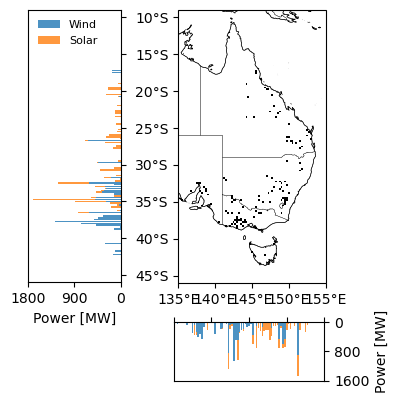

In [85]:
fig = plt.figure(dpi=100, figsize=(3.45, 3.9)) 

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0., right=0.27, bottom=0.302, top=1)
ax1 = plt.subplot(gs1[0])
plot_lat(ax1)

gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.3, right=1, bottom=0.3, top=1)
ax2 = plt.subplot(gs2[0], projection=ccrs.PlateCarree())
plot_facilities_map(ax2)

gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.423, right=0.86, bottom=0.05, top=0.2)
ax3 = plt.subplot(gs3[0])
plot_lon(ax3)

# plt.savefig('./figures/wind_solar_corr_and_gen_cap.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Power output

Capacity factor [-] multiplied by generator capacity [MW]

In [20]:
def calculate_power(region, solar_da, wind_da, facilities):
    """
    Calculate power for each site in this region.
    
    region: str, code of desired state e.g. NSW, QLD
    solar_da: array, of solar capacity factors
    wind_da: array, of wind capacity factors
    facilities: dict of facilities data in dataframe
    """
    df = facilities[region]
    da_list = []
    for i in range(len(df)):
        site = df.iloc[i]

        # Calculate power according to energy type
        if site["Technology"] == "Wind":
            cf = sel_cell(wind_da, site)
        elif site["Technology"] == "Solar (Utility)":
            cf = sel_cell(solar_da, site)
        else:
            raise ValueError("Incorrect 'Technology'.")

        power = cf * site["Generator Capacity (MW)"]

        # Reformat array
        power = power.expand_dims({
            "name": [site["Facility Name"]]
        })
        power = power.assign_coords(
            region=("name", [site["Region"]]),
            technology=("name", [site["Technology"]]),
            generator_capacity=("name", [site["Generator Capacity (MW)"]])
        )
        power = power.rename("power")
        da_list.append(power)
        
    da = xr.concat(da_list, dim="name")
    
    return da.chunk({"name": -1, "time": -1})

In [21]:
def power_for_regions(solar_da, wind_da, facilities):
    """
    Get power for each region in a dataset.
    
    solar_da: array of solar capacity factors
    wind_da: array of wind capacity factors
    facilities: dict of facilities data in dataframe
    """
    da_list = []
    for region in facilities:
        power = calculate_power(region, solar_da, wind_da, facilities)
        power = power.assign_coords(region=("name", np.repeat(region, len(power["name"]))))
        da_list.append(power)
    power_concat = xr.concat(da_list, dim="name")
    
    power_concat = power_concat.chunk({"time": -1, "name": -1})
    
    return power_concat

In [22]:
def compute_site_power(years, facilities, method="van_der_Wiel"):
    """
    Compute power time series for each site and each year.
    
    years: range
    facilities: dict of facilities data in dataframe
    method: str, which method of capacity factors was used
    """
    site_power_list = []
    for year in years:
        w = load_hourly_cf(year, "wind", method=method).capacity_factor
        s = load_hourly_cf(year, "solar", method=method).capacity_factor
        p = power_for_regions(s, w, facilities)
        site_power_list.append(p)
    site_power = xr.concat(site_power_list, dim="time")
    site_power = site_power.chunk({"name": 82, "time": -1})
    return site_power

In [23]:
years = range(1940, 2024)

In [24]:
fp = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

In [30]:
site_power = compute_site_power(years, facilities, method="van_der_Wiel")

In [32]:
site_power.to_netcdf(fp + "site_power_" + "van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc")

# Aggregate by state

In [33]:
def compute_state_power(technology, power_da):
    """
    Total power by state for a given technology.
    
    technology: str, should be 'Wind', 'Solar (Utility)' or 'both'.
    power_da: array of power data
    """
    # Sum for all sites per state
    da_list = []
    for region in np.unique(power_da["region"]):
        da = power_da.where(power_da["region"] == region)
        
        if technology == "Wind":
            da = da.where(da["technology"] == "Wind")
        elif technology == "Solar (Utility)":
            da = da.where(da["technology"] == "Solar (Utility)")
        elif technology == "both":
            pass
        else:
            raise ValueError("Incorrect 'technology'.")
            
        state_p = da.sum("name")
        state_p = state_p.expand_dims({'region': [region]})
        da_list.append(state_p)
    state_power =  xr.concat(da_list, dim="region")
    return state_power#.chunk({"region": -1})

In [34]:
site_power = xr.open_mfdataset(fp + "site_power_" + "van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc")

## Wind power

In [85]:
wind_power = compute_state_power("Wind", site_power).compute()

In [86]:
wind_power = wind_power["power"]

Wind power capacities: 2210 - (10 + 22 solar) = 2180 MW on OpenNEM, 2125 MW for me:

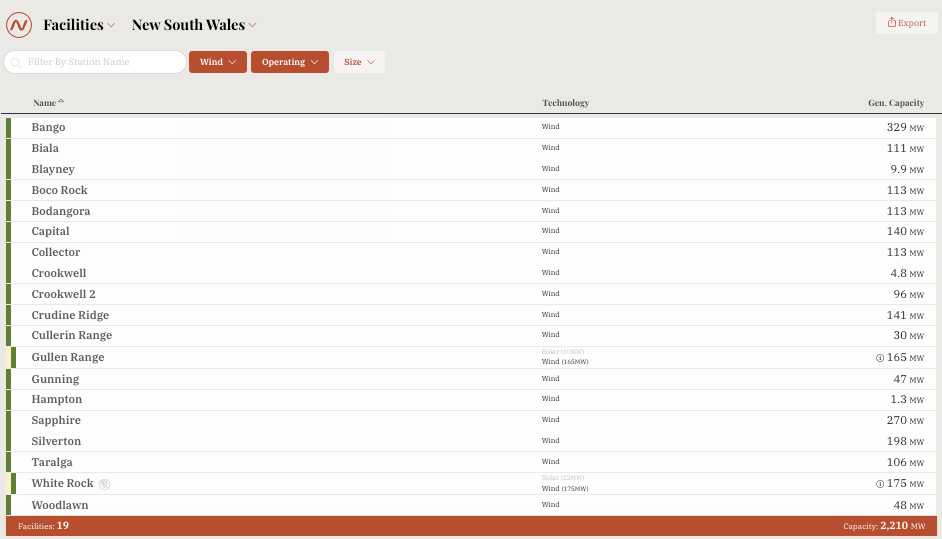

In [56]:
facilities["NSW"].loc[facilities["NSW"]["Technology"] == "Wind"]["Generator Capacity (MW)"].sum()

2125.69

According to OpenNEM, wind power generated 6000 GWh in June 2022 - June 2023, 16.5 GWh/day

https://opennem.org.au/energy/nsw1/?range=all&interval=1y

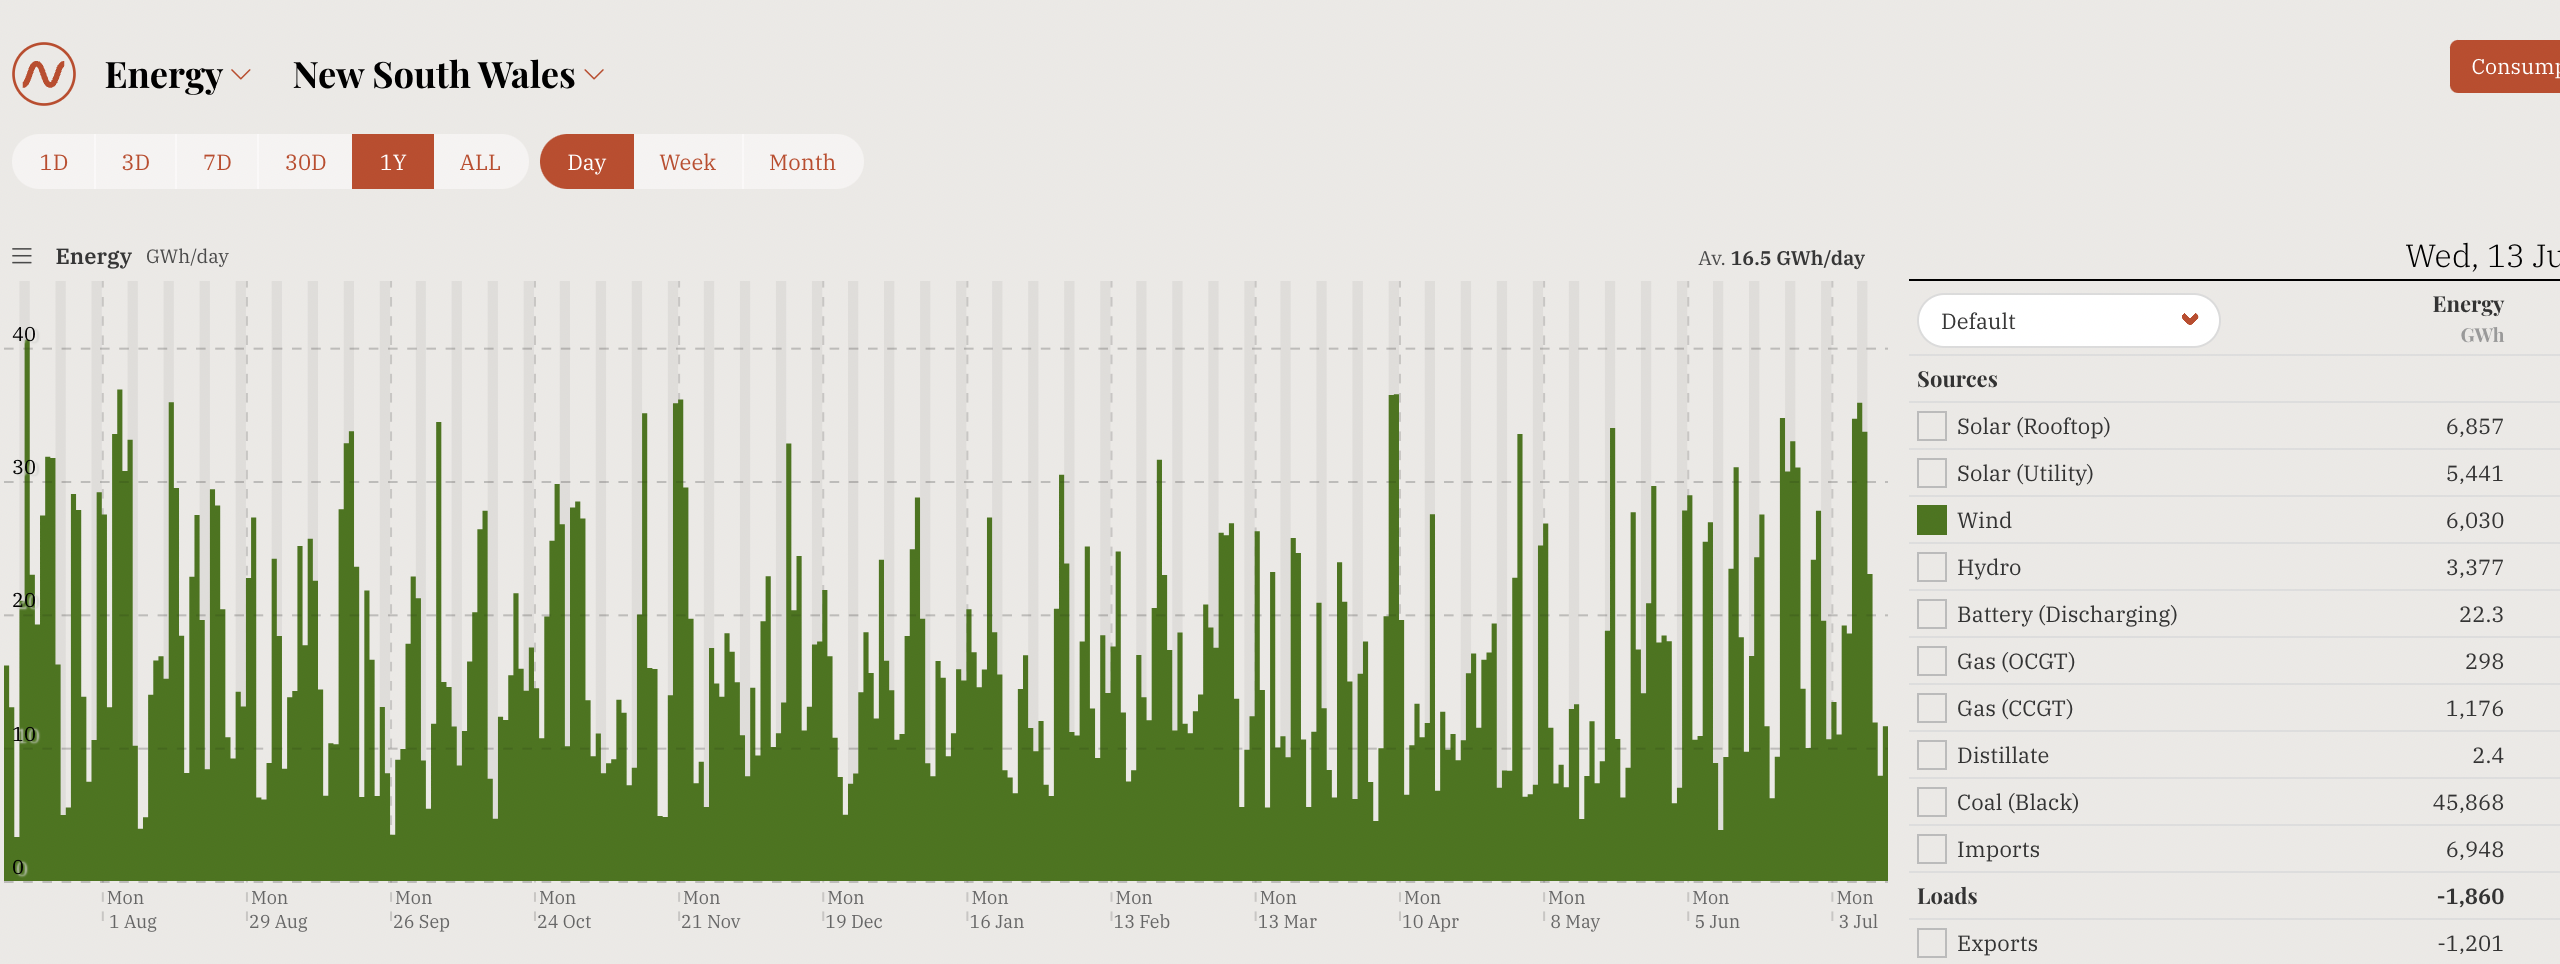

We don't get close to that, only achieving 7.4 GWh/day on average.

7.43002197265625 2711.958


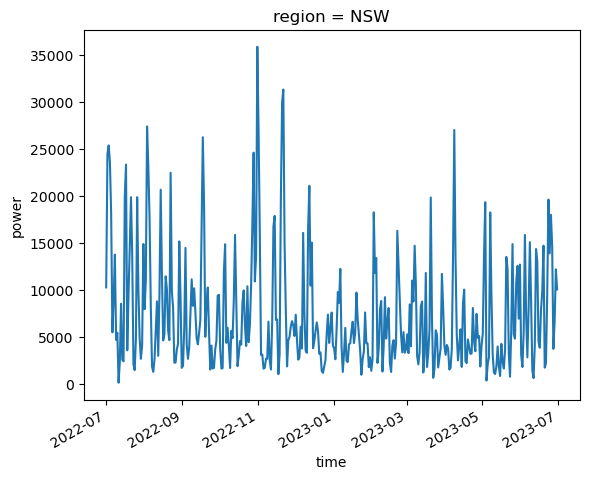

In [58]:
wind_power.sel(region="NSW", time=slice("2022-07", "2023-06")).coarsen(time=24).sum().plot()
print(wind_power.sel(region="NSW", time=slice("2022-07", "2023-06")).coarsen(time=24).sum().mean("time").values / 1000,
    wind_power.sel(region="NSW", time=slice("2022-07", "2023-06")).coarsen(time=24).sum().sum("time").values / 1000)

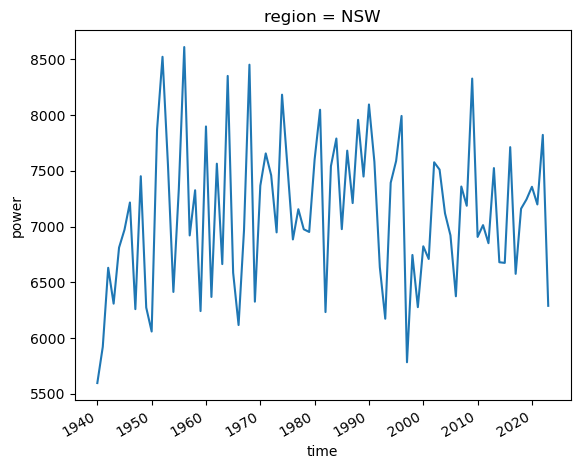

In [61]:
wind_power.sel(region="NSW").coarsen(time=24).sum().resample(time="1YS").mean().plot()

### Clearly some underestimation in wind power.

What does this look like for all states?

In [68]:
for s in states:
    print(s)
    print("2022: " + str(wind_power.sel(region=s, time="2022").sum().values) + " MWh / year")
    print("Annual avg.: " + str(wind_power.sel(region=s).resample(time="1YS").sum().mean().values) + " MWh / year\n")

NSW
2022: 2854879.2 MWh / year
Annual avg.: 2601817.5 MWh / year

QLD
2022: 715631.4 MWh / year
Annual avg.: 712447.0 MWh / year

SA
2022: 3626621.2 MWh / year
Annual avg.: 3496559.2 MWh / year

VIC
2022: 6031624.0 MWh / year
Annual avg.: 6133711.5 MWh / year

TAS
2022: 1323137.9 MWh / year
Annual avg.: 1384444.5 MWh / year



From OpenNEM, 2022 had the following MWh / year:

- NSW: 6.1 million
- QLD: 2 million
- SA: 6.5 million
- VIC: 9.7 million
- TAS: 1.6 million

This is a difference (scaling factor) of:

- NSW: (6.1m - 2.9m) = 3.2m (2.1)
- QLD: 1.28m (2.7)
- SA: 2.9m (1.8)
- VIC: 3.7m (1.6)
- TAS: 0.3m (1.23)

15.603044921875 5695.1115


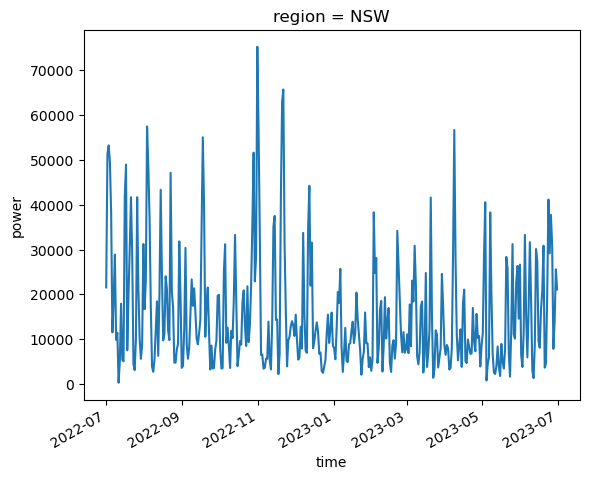

In [79]:
(wind_power.sel(region="NSW", time=slice("2022-07", "2023-06")) * 2.1).coarsen(time=24).sum().plot()
print(
    (wind_power.sel(region="NSW", time=slice("2022-07", "2023-06")) * 2.1).coarsen(time=24).sum().mean("time").values / 1000,
    (wind_power.sel(region="NSW", time=slice("2022-07", "2023-06")) * 2.1).coarsen(time=24).sum().sum("time").values / 1000
)

### Add these scaling factors to the dataset

In [87]:
wind_scaling_factors = {
    "NSW": 6114100 / 2854879,
    "QLD": 1908800 / 715631,
    "SA": 6530300 / 3626621,
    "TAS": 1632100 / 1323138,
    "VIC": 9754300 / 6031624
}

In [97]:
list(wind_scaling_factors.values())

[2.141631922053439,
 2.6672964139339967,
 1.8006568648888317,
 1.2335070113623825,
 1.6171929815253736]

In [98]:
wind_power = wind_power.assign_coords({
    "scale_factor_2022": ("region", list(wind_scaling_factors.values()))
})

In [99]:
wind_power

<xarray.DataArray 'power' (region: 5, time: 736344)>
array([[170.09477  , 149.87291  , 118.18744  , ..., 319.9192   ,
        188.68657  , 176.96417  ],
       [ 48.30048  ,  40.491917 ,  34.85984  , ...,  59.725937 ,
         37.57113  ,  48.6234   ],
       [ 85.07656  ,  51.448174 ,  50.541943 , ..., 201.31306  ,
        100.644615 ,  72.24963  ],
       [  8.99736  ,  10.914941 ,  15.883401 , ...,   0.       ,
          0.       ,   1.1031374],
       [214.74612  , 263.52228  , 318.83005  , ..., 137.7157   ,
         83.59419  ,  38.86059  ]], dtype=float32)
Coordinates:
  * region             (region) object 'NSW' 'QLD' 'SA' 'TAS' 'VIC'
  * time               (time) datetime64[ns] 1940-01-01 ... 2023-12-31T23:00:00
    scale_factor_2022  (region) float64 2.142 2.667 1.801 1.234 1.617

## Solar power

In [35]:
solar_power = compute_state_power("Solar (Utility)", site_power).compute()

In [51]:
solar_power = solar_power["power"]

Generation capacities are the same: 3218 MW in NSW.

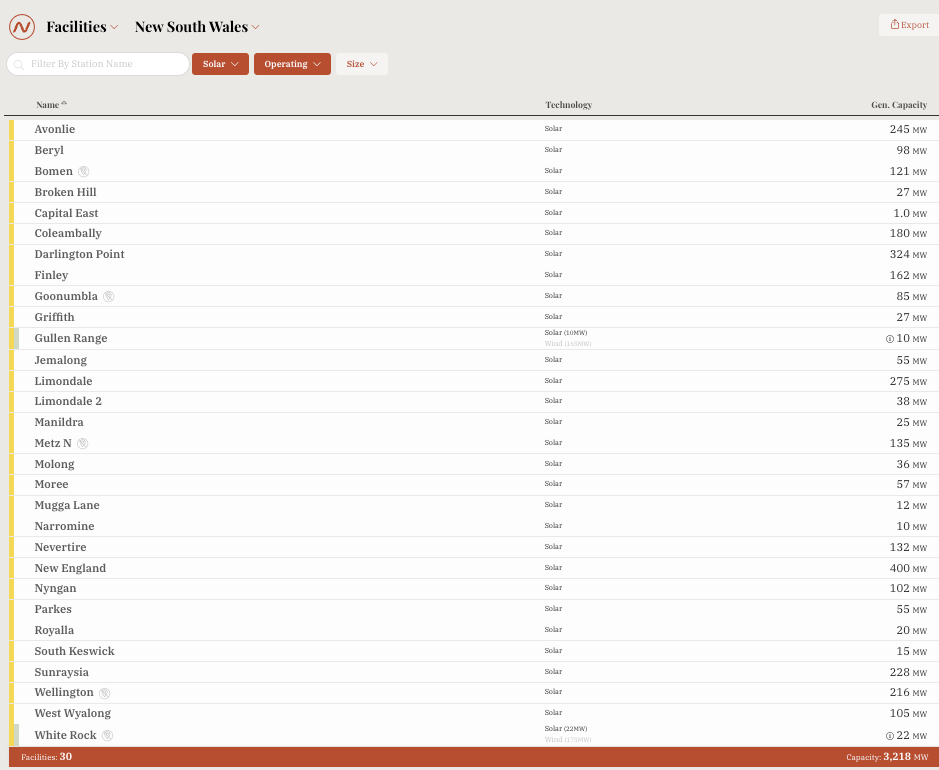

In [38]:
facilities["NSW"].loc[facilities["NSW"]["Technology"] == "Solar (Utility)"]["Generator Capacity (MW)"].sum()

3218.0

For NSW, we see an average power of 14.9 GWh/day. This compares well with OpenNEM data, which shows a 14.9 GWh/day for Jun 2022 - June 2023.

https://opennem.org.au/energy/nsw1/?range=1y&interval=1d

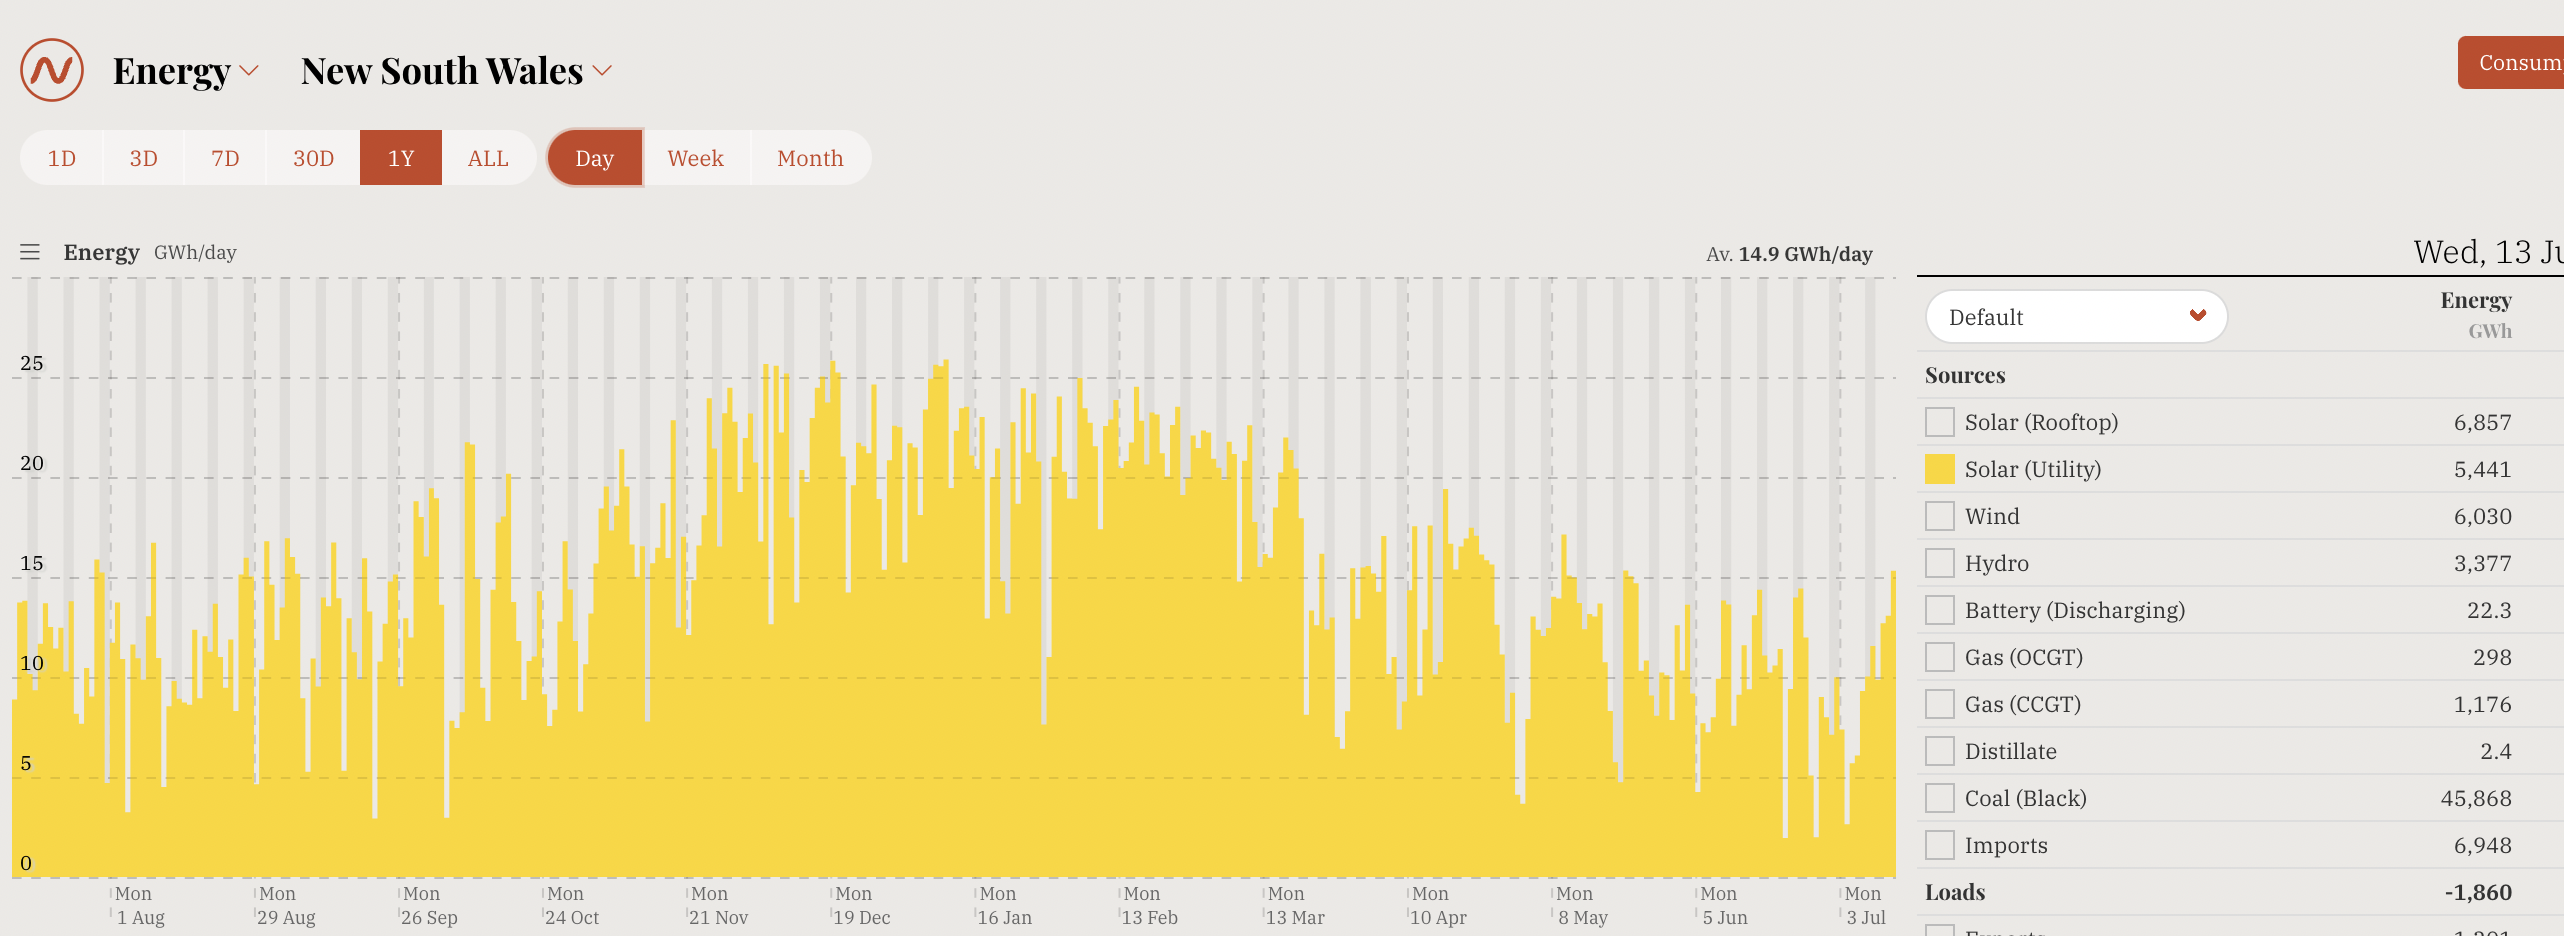

14.9553916015625 5458.718


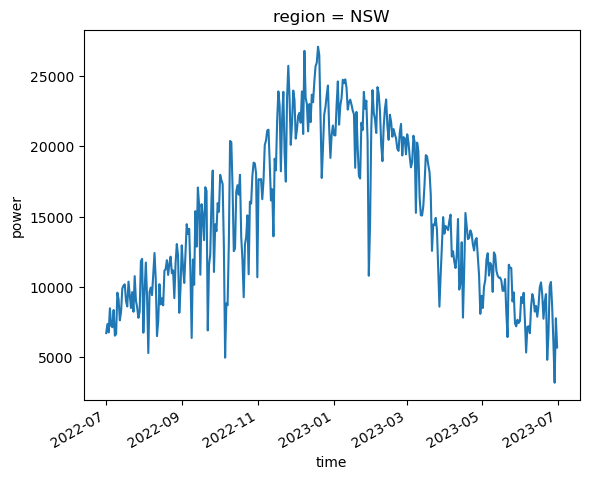

In [59]:
solar_power.sel(region="NSW", time=slice("2022-07", "2023-06")).coarsen(time=24).sum().plot()
print(solar_power.sel(region="NSW", time=slice("2022-07", "2023-06")).coarsen(time=24).sum().mean("time").values / 1000,
    solar_power.sel(region="NSW", time=slice("2022-07", "2023-06")).coarsen(time=24).sum().sum("time").values / 1000)

### scaling factors

In [100]:
for s in states:
    print(s)
    print("2022: " + str(solar_power.sel(region=s, time="2022").sum().values) + " MWh / year")
    print("Annual avg.: " + str(solar_power.sel(region=s).resample(time="1YS").sum().mean().values) + " MWh / year\n")

NSW
2022: 5242788.0 MWh / year
Annual avg.: 5722840.0 MWh / year

QLD
2022: 4577404.0 MWh / year
Annual avg.: 4814630.0 MWh / year

SA
2022: 955442.2 MWh / year
Annual avg.: 1023840.56 MWh / year

VIC
2022: 1435584.6 MWh / year
Annual avg.: 1561147.4 MWh / year

TAS
2022: 0.0 MWh / year
Annual avg.: 0.0 MWh / year



In [87]:
solar_scaling_factors = {
    "NSW": 6114100 / 2854879,
    "QLD": 4167100 / 4577404,
    "SA": 6530300 / 3626621,
    "TAS": 1632100 / 1323138,
    "VIC": 9754300 / 6031624
}

In [97]:
list(wind_scaling_factors.values())

[2.141631922053439,
 2.6672964139339967,
 1.8006568648888317,
 1.2335070113623825,
 1.6171929815253736]

In [98]:
wind_power = wind_power.assign_coords({
    "scale_factor_2022": ("region", list(wind_scaling_factors.values()))
})

In [99]:
wind_power

<xarray.DataArray 'power' (region: 5, time: 736344)>
array([[170.09477  , 149.87291  , 118.18744  , ..., 319.9192   ,
        188.68657  , 176.96417  ],
       [ 48.30048  ,  40.491917 ,  34.85984  , ...,  59.725937 ,
         37.57113  ,  48.6234   ],
       [ 85.07656  ,  51.448174 ,  50.541943 , ..., 201.31306  ,
        100.644615 ,  72.24963  ],
       [  8.99736  ,  10.914941 ,  15.883401 , ...,   0.       ,
          0.       ,   1.1031374],
       [214.74612  , 263.52228  , 318.83005  , ..., 137.7157   ,
         83.59419  ,  38.86059  ]], dtype=float32)
Coordinates:
  * region             (region) object 'NSW' 'QLD' 'SA' 'TAS' 'VIC'
  * time               (time) datetime64[ns] 1940-01-01 ... 2023-12-31T23:00:00
    scale_factor_2022  (region) float64 2.142 2.667 1.801 1.234 1.617

# Close cluster

In [32]:
client.close()
cluster.close()